In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Defining Transforms

In [2]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [3]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, label_file, class_names, class_to_idx, transform):
        self.root_dir = root_dir
        self.label_file = label_file
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.transform = transform

        # Read the labels from the Excel file
        self.labels = pd.read_excel(label_file, usecols=[2], names=['face_shape'])['face_shape'].tolist()

        # Get the list of image files (without the lambda it was not in order)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir): 
            self.image_files.extend([os.path.join(root, file) for file in sorted(files, key=lambda x: int(''.join(filter(str.isdigit, x))))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and apply the transformation
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])
        
        return image, label

# Define the root directory of the dataset and the label file
root_dir = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\cartoon_set\img'
label_file = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\cartoon_set\labels.xlsx'
root_dir_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\cartoon_set_test\img'
label_file_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\cartoon_set_test\labels.xlsx'

# Define the class names and their corresponding indexes
class_names = ['Shape0', 'Shape1', 'Shape2', 'Shape3', 'Shape4']
class_to_idx = {'Shape0': 0, 'Shape1': 1, 'Shape2': 2, 'Shape3': 3, 'Shape4': 4}

train_data = MyDataset(root_dir, label_file, class_names, class_to_idx, transform=train_transform)
test_data = MyDataset(root_dir_test, label_file_test, class_names, class_to_idx, transform=test_transform)

torch.manual_seed(42)

# val_ratio = 0.2 # ratio of the validation set (e.g., 0.2 for 20% of the data)
# indices = torch.randperm(len(train_data)).tolist() # Get the indices of the data points in the training set
# val_size = int(val_ratio * len(train_data)) # number of data points in the validation set

# # Split the indices into training and validation sets
# val_indices = indices[:val_size]
# train_indices = indices[val_size:]

# # Create the samplers for the training and validation sets
# train_sampler = SubsetRandomSampler(train_indices)
# val_sampler = SubsetRandomSampler(val_indices)

# Create the DataLoader objects for the training and validation sets
train_loader = DataLoader(train_data, batch_size=125, shuffle=True)
# val_loader = DataLoader(train_data, batch_size=125, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=125, shuffle=True)

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')



['Shape0', 'Shape1', 'Shape2', 'Shape3', 'Shape4']
Training images available: 10000
Testing images available:  2500


# Defining the model

In [4]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # (((500−2)/2)−2)/2=123.5
        # (((500−2)/2)−2)/2=123.5
        self.fc1 = nn.Linear(123*123*16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 123*123*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [5]:
torch.manual_seed(42)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=242064, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)

In [7]:
import time
start_time = time.time()

epochs = 10

# Limit nr of batches for testing
#max_trn_batch = 10
#max_val_batch = 2

train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1 # For the calculations later

        # Limit the number of batches for testing
        #if b == max_trn_batch:
        #    break

        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%(40) == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{125*b:4}/10000]  loss: {loss.item():10.8f}  |  accuracy: {trn_corr.item()*100/(125*b):7.2f}%   |   Duration: {time.time() - start_time:.0f} seconds')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches for test
            #if b == max_val_batch:
            #    break

            # Apply the model
            y_val_pred = CNNmodel(X_test)
            loss = criterion(y_val_pred, y_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val_pred.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    val_losses.append(loss.item())
    val_correct.append(tst_corr.item())

epoch:  0  batch:   40 [5000/10000]  loss: 0.37641659  |  accuracy:   53.52%   |   Duration: 455 seconds
epoch:  0  batch:   80 [10000/10000]  loss: 0.00369223  |  accuracy:   75.70%   |   Duration: 882 seconds
epoch:  1  batch:   40 [5000/10000]  loss: 0.00231057  |  accuracy:   99.76%   |   Duration: 1411 seconds
epoch:  1  batch:   80 [10000/10000]  loss: 0.00490346  |  accuracy:   99.78%   |   Duration: 1840 seconds
epoch:  2  batch:   40 [5000/10000]  loss: 0.00592049  |  accuracy:   99.90%   |   Duration: 2376 seconds
epoch:  2  batch:   80 [10000/10000]  loss: 0.00178661  |  accuracy:   99.89%   |   Duration: 2803 seconds
epoch:  3  batch:   40 [5000/10000]  loss: 0.00215443  |  accuracy:   99.80%   |   Duration: 3335 seconds
epoch:  3  batch:   80 [10000/10000]  loss: 0.00021068  |  accuracy:   99.77%   |   Duration: 3761 seconds
epoch:  4  batch:   40 [5000/10000]  loss: 0.00018187  |  accuracy:  100.00%   |   Duration: 4317 seconds
epoch:  4  batch:   80 [10000/10000]  loss: 

Inspect results


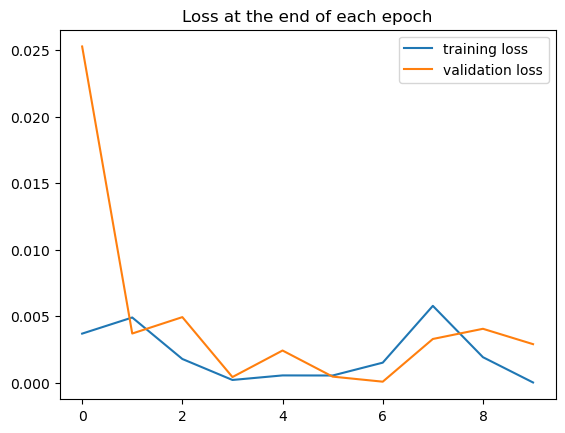

In [11]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()


[2487, 2498, 2499, 2499, 2495, 2500, 2500, 2495, 2498, 2500]
Test accuracy: 100.000%


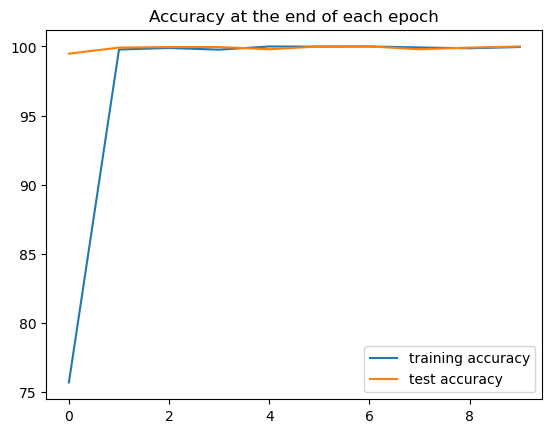

In [12]:
print(val_correct)
print(f'Test accuracy: {val_correct[-1]*100/2500:.3f}%')
plt.plot([t/100 for t in train_correct], label='training accuracy')
plt.plot([t/25 for t in val_correct], label='test accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [10]:
torch.save(CNNmodel.state_dict(), 'B2CNNModelFinal.pt')

# Using pre trained model

In [12]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
# Freezing parameters
for param in AlexNetmodel.parameters():
    param.requires_grad = False

# modifying classifier
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)



In [14]:
import time
start_time = time.time()

epochs = 10

max_trn_batch = 78 # 78 * 64 = 4992
max_tst_batch = 15 # 15 * 64 = 960

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
        
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Changing the labels to be in the range [0, num_classes-1].
        y_train = torch.where(y_train == 1, torch.tensor(1), torch.tensor(0))

        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%(max_trn_batch/2) == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{64*b:4}/4992]  loss: {loss.item():10.8f}  \  accuracy: {trn_corr.item()*100/(64*b):7.2f}%')

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Changing the labels to be in the range [0, num_classes-1].
            y_test = torch.where(y_test == 1, torch.tensor(1), torch.tensor(0))

            # Apply the model
            y_val = AlexNetmodel(X_test)
            loss = criterion(y_val, y_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   39 [2496/4992]  loss: 0.33308563  \  accuracy:   80.17%
epoch:  0  batch:   78 [4992/4992]  loss: 0.21871282  \  accuracy:   83.91%
epoch:  1  batch:   39 [2496/4992]  loss: 0.14163335  \  accuracy:   90.30%
epoch:  1  batch:   78 [4992/4992]  loss: 0.34384030  \  accuracy:   90.28%
epoch:  2  batch:   39 [2496/4992]  loss: 0.17188208  \  accuracy:   92.43%
epoch:  2  batch:   78 [4992/4992]  loss: 0.16328666  \  accuracy:   92.09%
epoch:  3  batch:   39 [2496/4992]  loss: 0.18992545  \  accuracy:   92.35%
epoch:  3  batch:   78 [4992/4992]  loss: 0.09322051  \  accuracy:   92.61%
epoch:  4  batch:   39 [2496/4992]  loss: 0.11236255  \  accuracy:   93.43%
epoch:  4  batch:   78 [4992/4992]  loss: 0.10490441  \  accuracy:   92.87%
epoch:  5  batch:   39 [2496/4992]  loss: 0.12805697  \  accuracy:   92.83%
epoch:  5  batch:   78 [4992/4992]  loss: 0.23380132  \  accuracy:   92.65%
epoch:  6  batch:   39 [2496/4992]  loss: 0.20474167  \  accuracy:   94.27%
epoch:  6  b

In [15]:
torch.save(AlexNetmodel.state_dict(), 'AlexNetModel64.pt')

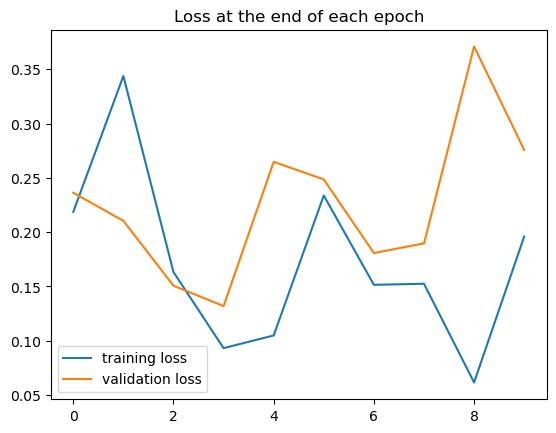

In [16]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

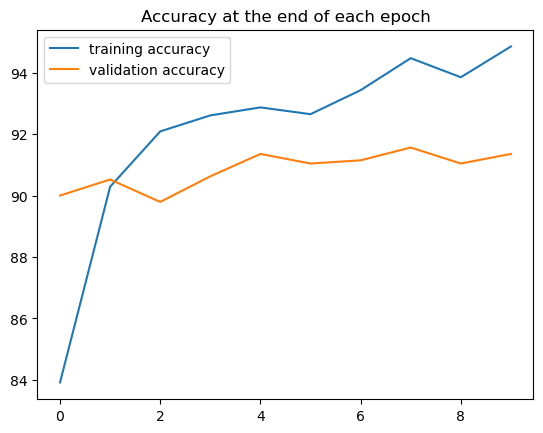

In [17]:
plt.plot([t/49.92 for t in train_correct], label='training accuracy')
plt.plot([t/9.60 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [18]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1]*100/960:.3f}%')

[864, 869, 862, 870, 877, 874, 875, 879, 874, 877]
Test accuracy: 91.354%
